In [1]:
import pandas as pd
import numpy as np

batting = pd.read_csv("Batting.csv")
people = pd.read_csv("People.csv")

# necessary columns
bat_cols = [
    'playerID', 'yearID', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR',
    'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF',
]
batting = batting[bat_cols]


# calculate rate stats
# ----------------------------
# Avoid division by zero
batting['PA'] = batting[['AB','BB','HBP','SH','SF']].fillna(0).sum(axis=1)

# Batting average
batting['AVG'] = batting['H'] / batting['AB'].replace(0, np.nan)

# On-base percentage
batting['OBP'] = (
    batting['H'] + batting['BB'] + batting['HBP']
) / (
    batting['AB'] + batting['BB'] + batting['HBP'] + batting['SF']
).replace(0, np.nan)

# Slugging percentage
batting['SLG'] = (
    batting['H'] 
    + batting['2B'] 
    + 2*batting['3B'] 
    + 3*batting['HR']
) / batting['AB'].replace(0, np.nan)

# OPS = OBP + SLG
batting['OPS'] = batting['OBP'] + batting['SLG']

# merge with people set to get age
people_small = people[['playerID', 'birthYear']]
df = batting.merge(people_small, on='playerID', how='left')

# Age that season
df['age'] = df['yearID'] - df['birthYear']

df = df.sort_values(['playerID', 'yearID'])

df['OPS_next_year'] = df.groupby('playerID')['OPS'].shift(-1)

# Drop rows without next-season OPS
df = df.dropna(subset=['OPS_next_year'])

# clean up missing values
df = df.dropna(subset=['OPS', 'OBP', 'SLG', 'AVG', 'AB', 'PA', 'age'])

# filter by 250 or more plate appearances
df = df[df['PA'] >= 250]

# Final dataset
df_final = df.copy()

print("Final dataset shape:", df_final.shape)
df_final.head()


Final dataset shape: (16991, 26)


,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,...,SH,SF,PA,AVG,OBP,SLG,OPS,birthYear,age,OPS_next_year
9,aaronha01,1954,122,468,58,131,27,6,13,69.0,...,6.0,4.0,509.0,0.279915,0.322068,0.446581,0.768649,1934.0,20.0,0.906129
10,aaronha01,1955,153,602,105,189,37,9,27,106.0,...,7.0,4.0,665.0,0.313953,0.366261,0.539867,0.906129,1934.0,21.0,0.923178
11,aaronha01,1956,153,609,106,200,34,14,26,92.0,...,5.0,7.0,660.0,0.328407,0.364885,0.558292,0.923178,1934.0,22.0,0.977778
12,aaronha01,1957,151,615,118,198,27,6,44,132.0,...,0.0,3.0,675.0,0.321951,0.377778,0.600000,0.977778,1934.0,23.0,0.931299
13,aaronha01,1958,153,601,109,196,34,4,30,95.0,...,0.0,3.0,664.0,0.326123,0.385542,0.545757,0.931299,1934.0,24.0,1.037084


<class 'pandas.core.frame.DataFrame'>
Index: 16991 entries, 9 to 115418
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   playerID       16991 non-null  object 
 1   yearID         16991 non-null  int64  
 2   G              16991 non-null  int64  
 3   AB             16991 non-null  int64  
 4   R              16991 non-null  int64  
 5   H              16991 non-null  int64  
 6   2B             16991 non-null  int64  
 7   3B             16991 non-null  int64  
 8   HR             16991 non-null  int64  
 9   RBI            16991 non-null  float64
 10  SB             16991 non-null  float64
 11  CS             16991 non-null  float64
 12  BB             16991 non-null  int64  
 13  SO             16991 non-null  float64
 14  IBB            16842 non-null  float64
 15  HBP            16991 non-null  float64
 16  SH             16991 non-null  float64
 17  SF             16991 non-null  float64
 18  PA        

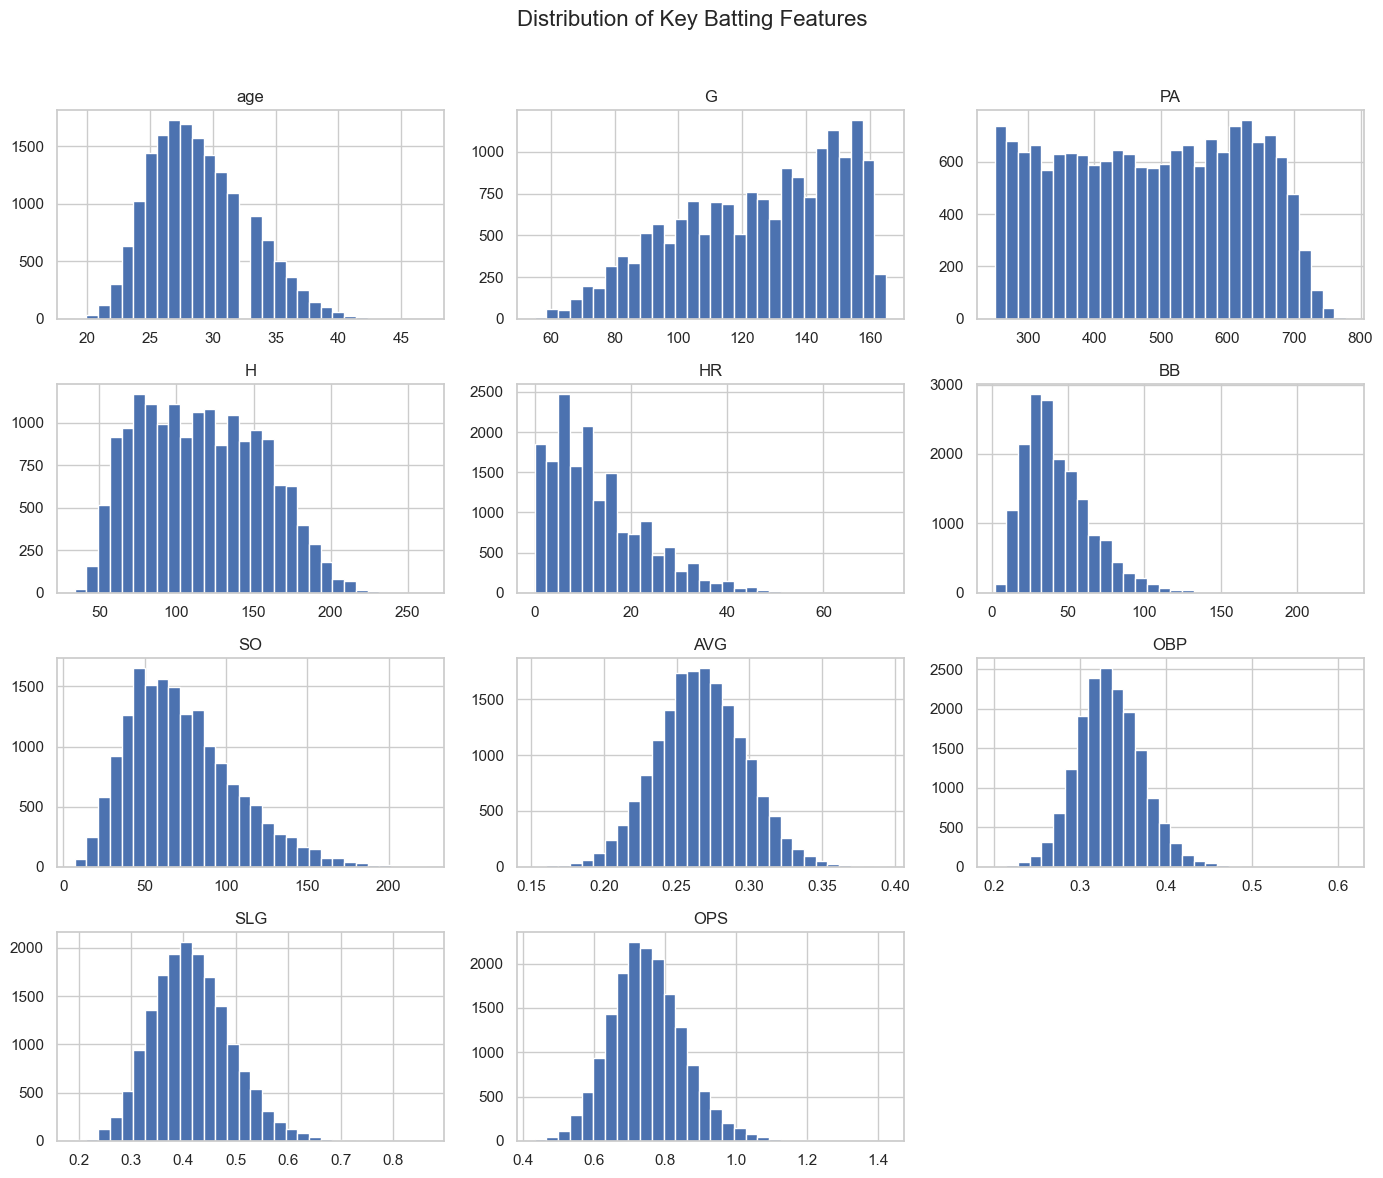

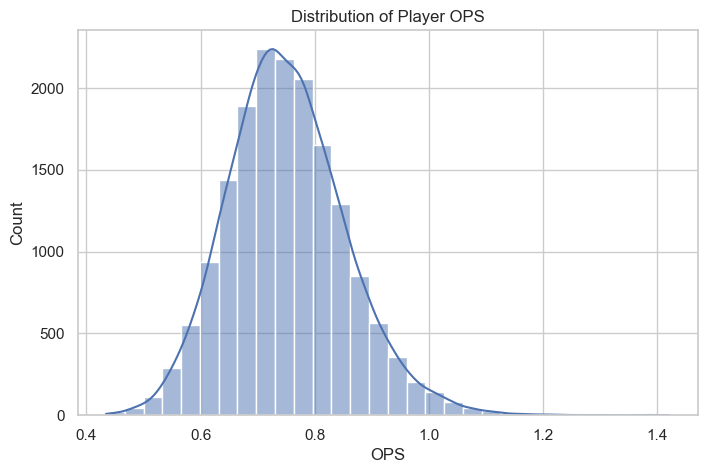

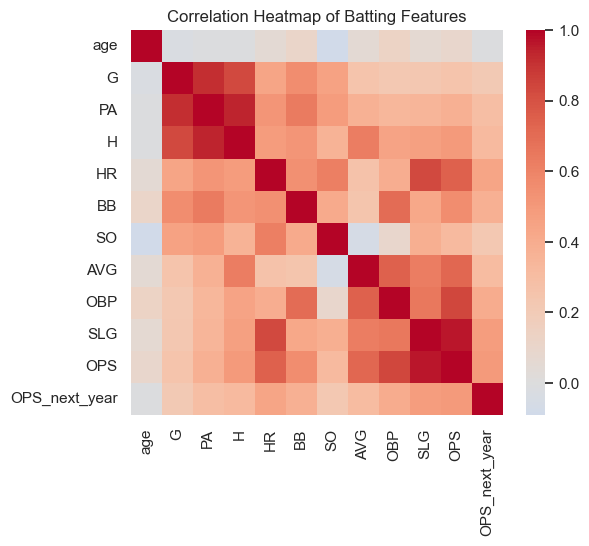

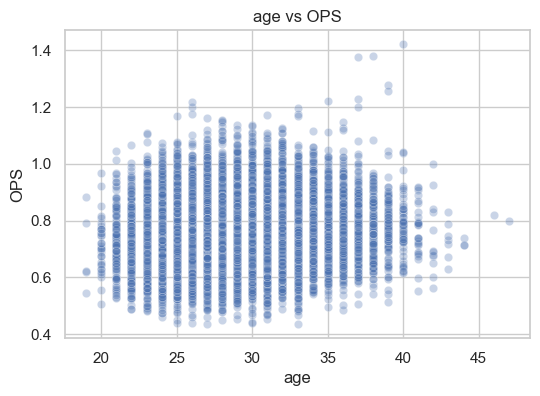

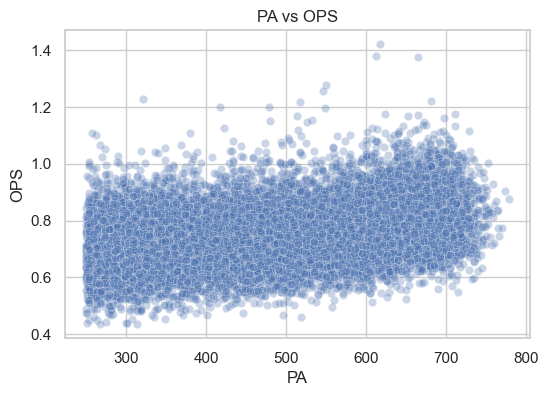

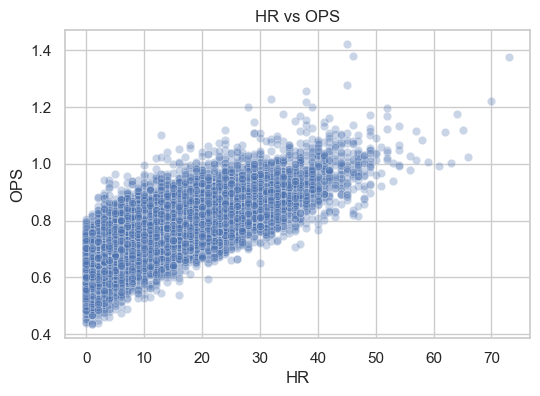

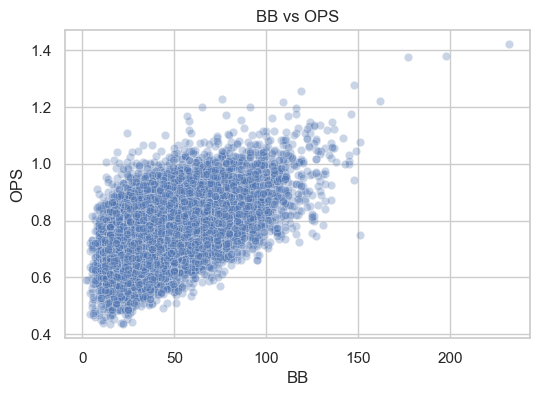

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# clean
sns.set(style="whitegrid", context="notebook")

# Define key features list
features = ['age', 'G', 'PA', 'H', 'HR', 'BB', 'SO', 'AVG', 'OBP', 'SLG', 'OPS']

print(df_final.info())
print(df_final.describe().T)


# Histograms of key features

df_final[features].hist(bins=30, figsize=(14, 12)) 
plt.suptitle("Distribution of Key Batting Features", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# distribution of OPS
plt.figure(figsize=(8,5))
sns.histplot(df_final['OPS'], bins=30, kde=True)
plt.title("Distribution of Player OPS")
plt.xlabel("OPS")
plt.ylabel("Count")
plt.show()

# correlation heatmap
plt.figure(figsize=(6, 5)) 
corr = df_final[features + ['OPS_next_year']].corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0) 
plt.title("Correlation Heatmap of Batting Features")
plt.show()


scatter_pairs = [
    ('age', 'OPS'),
    ('PA', 'OPS'),
    ('HR', 'OPS'),
    ('BB', 'OPS'),
]

for x, y in scatter_pairs:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df_final, x=x, y=y, alpha=0.3)
    plt.title(f"{x} vs {y}")
    plt.show()

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# load Pitching.csv to find pitchers
pitching = pd.read_csv("Pitching.csv")

pitcher_ids = pitching['playerID'].unique()

# Remove pitchers from df_final
df_np = df_final[~df_final['playerID'].isin(pitcher_ids)].copy()

print("Dataset after removing pitchers:", df_np.shape)

feature_cols = [
    'age', 'G', 'PA', 'H', '2B', '3B', 'HR', 'BB', 'SO',
    'SB', 'CS', 'AVG', 'OBP', 'SLG'
]

# include yearID in X temporarily for the split
X = df_np[feature_cols + ['yearID']]
y = df_np['OPS_next_year']

# Time-Series Train/Test Split
# NOTE: We assume 'yearID' is temporarily included in X for this split.
# If not, you must merge 'yearID' back into X before this step.
#
# Set a cutoff year for training 
cutoff_year = 2005

# Split the data chronologically based on yearID
X_train_full = X[X['yearID'] < cutoff_year].copy()
X_test_full = X[X['yearID'] >= cutoff_year].copy()
y_train = y[X['yearID'] < cutoff_year].copy()
y_test = y[X['yearID'] >= cutoff_year].copy()

# Drop the 'yearID' column from the feature sets before training/scaling
X_train = X_train_full.drop('yearID', axis=1)
X_test = X_test_full.drop('yearID', axis=1)

print("Training samples (pre-", cutoff_year, "):", X_train.shape)
print("Testing samples (post-", cutoff_year, "):", X_test.shape)

# scaling for linear regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Dataset after removing pitchers: (15259, 26)
Training samples (pre- 2005 ): (10976, 14)
Testing samples (post- 2005 ): (4283, 14)


TESTING -- 
Lin Reg Train Performance:
R²: 0.298, MAE: 0.082, RMSE: 0.121

Ran For Train Performance:
R²: 0.391, MAE: 0.076, RMSE: 0.112

Linear Regression Performance:
R²: 0.217, MAE: 0.087, RMSE: 0.126

Random Forest Performance:
R²: 0.213, MAE: 0.088, RMSE: 0.126



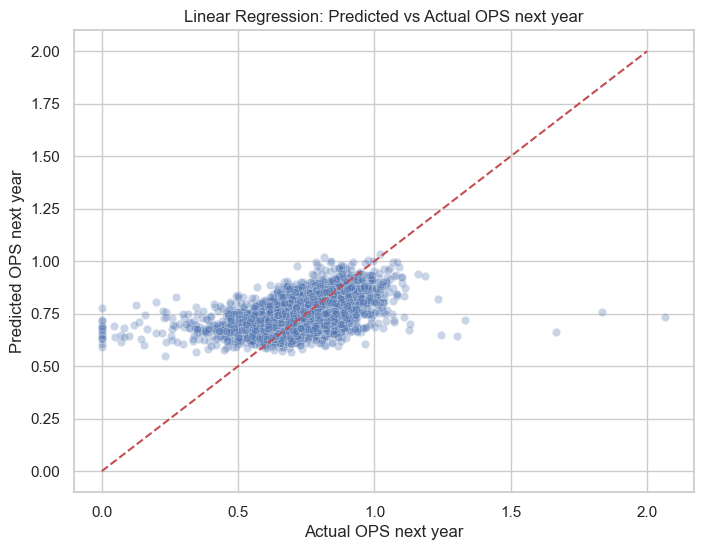

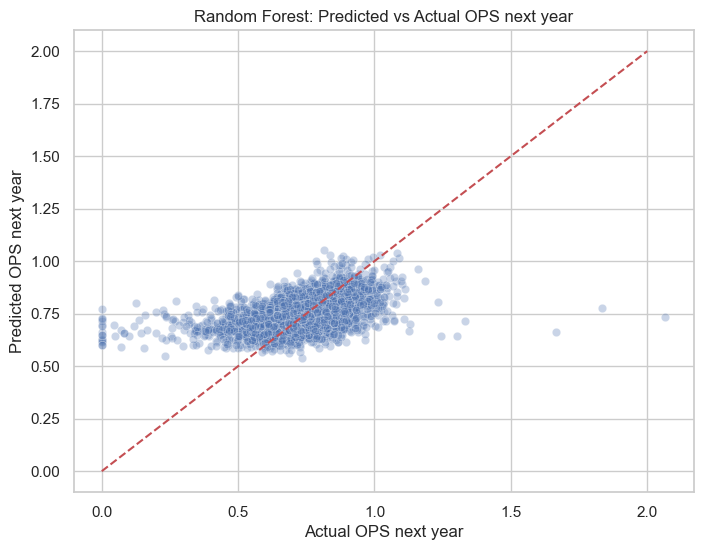

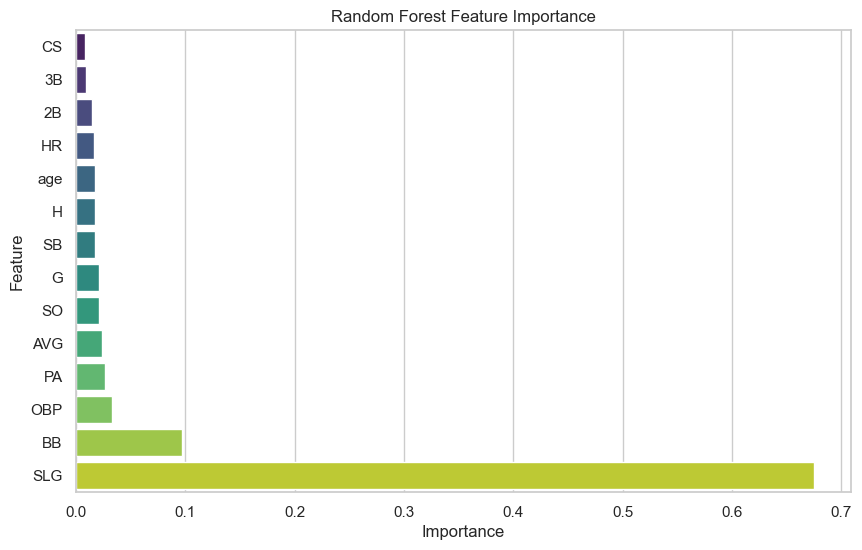

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set(style="whitegrid", context="notebook")

# train linear regression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred_lr_tr = lr.predict(X_train_scaled)



y_pred_lr = lr.predict(X_test_scaled)

# train random forest
rf = RandomForestRegressor(
    n_estimators=200, 
    random_state=42,
    # 1. New: Max depth of the tree
    max_depth=10, 
    # 2. New: Minimum samples needed to split a node
    min_samples_split=50, 
    # 3. New: Minimum samples allowed in a terminal leaf node
    min_samples_leaf=25 
)
rf.fit(X_train, y_train)

y_pred_rf_tr = rf.predict(X_train)

y_pred_rf = rf.predict(X_test)

# evaluate models
def regression_metrics(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{model_name} Performance:")
    print(f"R²: {r2:.3f}, MAE: {mae:.3f}, RMSE: {rmse:.3f}\n")
    return r2, mae, rmse
print("TESTING -- ")
a, b, c = regression_metrics(y_train, y_pred_lr_tr, "Lin Reg Train")
x, y, z = regression_metrics(y_train, y_pred_rf_tr, "Ran For Train")
      
r2_lr, mae_lr, rmse_lr = regression_metrics(y_test, y_pred_lr, "Linear Regression")
r2_rf, mae_rf, rmse_rf = regression_metrics(y_test, y_pred_rf, "Random Forest")

# visualize
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.3)
plt.plot([0,2], [0,2], 'r--')  # perfect prediction line
plt.title("Linear Regression: Predicted vs Actual OPS next year")
plt.xlabel("Actual OPS next year")
plt.ylabel("Predicted OPS next year")
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.3)
plt.plot([0,2], [0,2], 'r--')  # perfect prediction line
plt.title("Random Forest: Predicted vs Actual OPS next year")
plt.xlabel("Actual OPS next year")
plt.ylabel("Predicted OPS next year")
plt.show()

# feature importance (for random forest)
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=True)  # ascending=True for horizontal plot

plt.figure(figsize=(10,6))
sns.barplot(
    data=feature_importance_df,
    x='importance',
    y='feature',
    dodge=False,
    palette='viridis',
    hue='feature',
    legend=False
)
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()
